# EDA - Capstone 1
***

## Beer Review Data Description
***

The dataset contains over 1.5 million reviews of various beers from two websites: BeerAdvocate.com. This data not only includes user reviews, product category and alcohol by volume(ABV), but sensory aspects as well such as taste, look, smell and overall ratings. For this project I will train and test models to predict beer ratings and beer style based off the user reviews that were left.

These reviews were made available by Julian Mcauley, a UCSD Computer Science professor, from a collection period of January 1998 to November 2011. This dataset was accessed with permssion. Here are some key specs of the dataset itself.
+ Number of users: 33,387
+ Number of items: 66,051
+ Number of reviews: 1,586,259
    
To tackle the issue of size, I will take a subset sample of 99,999 reviews to train and test our models before applying it to the rest of the dataset. 

I previously cleaned the data to remove unnecessary columns and break down the text review. Now it's time to explore the data.

In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

In [2]:
beer = pd.read_csv('beercleaned.csv')

In [3]:
beer = beer.drop(['Unnamed: 0'], axis=1)

## Define Functions
I will define some functions for later use.
+ Information on Different Styles of Beer
+ Box Plots per Rating Category
+ Histograms for brands of beer with 10+ Reviews
+ Log Conversion 
+ Ratings Conversion 


In [4]:
def beer_style_info(df, title):
    """Displays Various Information of each DataFrame including: Style of beers, brands, number or reviews, etc.
       Also displays the rating distribtuion from 1-5 in the four categories: palate, taste, appearance, and aroma"""
    print('\n', title, '\n-----------------------------')
    print('Number of Different Brands:   ', len(df['name'].value_counts()))
    print('Number of Reviews:            ', len(df['text'].value_counts()))
    print('Average Word Count per Review:', df['word_count'].mean())
    print('Average Reviews per Brand:    ', round(df['name'].value_counts().mean()))
    print('Number of Reviewers:          ', len(df['profileName'].value_counts()))
    print('Reviews per Brand:            ', min(df['name'].value_counts()), '-', max(df['name'].value_counts()))
    
    ratings = pd.DataFrame(columns=['appearance', 'taste', 'aroma', 'palate'])
    ratings['appearance'] = df.appearance.value_counts()
    ratings['taste'] = df.taste.value_counts()
    ratings['aroma'] = df.aroma.value_counts()
    ratings['palate'] = df.palate.value_counts()
    return ratings.sort_index()

def rating_box_plot(rater, df1, df2):
    """Create boxplots of the distribution of ratings for each category
           rater: Category of rating for interest in spread
           df1: main dataframe where all data comes from
           df2: subset or differnet dataframe where different styles can be looked at once
    """
    sns.set()
    plt.figure(figsize=(15, 10))
    
    plt.subplot(211)
    all_beer = sns.boxplot(x=rater, data=df1, color = 'goldenrod', showmeans=True,
                           meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black", 
                                      "markersize":10})
    plt.title('Distribution of Rating for all Beers')
    plt.ylabel('All Beers')
    plt.xlabel('Rating')
    
    plt.subplot(212)
    style_beer = sns.boxplot(x=rater, y='style', data=df2, orient="h", showmeans=True,
                             meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black", 
                                      "markersize":10})
    plt.title('Distribution of Rating by Beer Style')
    plt.xlabel('Rating')   
    plt.tight_layout()
    plt.show()


def ten_plus_reviews(df, col, rater, c):
    """Create histogram for the average rating of brands of beer with more than 10 reviews.
           df: dataframe 
           col: brands of beer
           rater: rating category(Appearance, Aroma, Palate or Taste)
           c: color of histogram
    """
    # Group beers by brand
    reviews_per_brand = df.groupby(col)
    
    # Count number of reviews per beer
    counts = reviews_per_brand[col].count()
    
    # Calculate the mean rating for each brand of beer
    means = reviews_per_brand[rater].mean()

    # Only plot the mean rating for brands of beers that have more than 10 reviews
    means[counts > 10].hist(bins=10, color = c)
    plt.axvline(means[counts > 10].mean(), color='k', linestyle='dashed', linewidth=1)
    
def log_transformation(df):
    """ Transform word_count by log to normalize it"""
    df = df.assign(log_word_count = lambda x: np.log(x.word_count))
    return dataf

def convert_ratings(df, col_name, rater):
    """Convert 5 rating scale into 3 groups
       1,2 - Low
       3 - Medium
       4,5 - High
    """
    df[col_name] = np.where(df[rater] > 3, 'high', 
             (np.where(df[rater] < 3, 'low', 'medium')))

## Beer Styles

First I will look at the number of reviews per style of beer. 

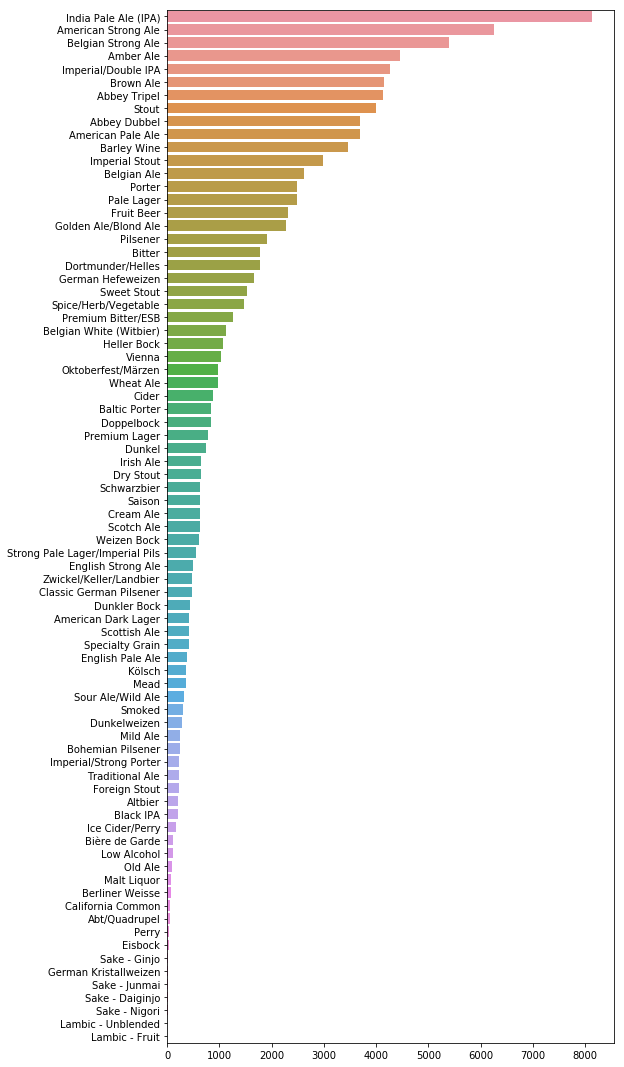

In [5]:
style_count = pd.value_counts(beer['style'].values, sort=True)

plt.figure(figsize=(8,19))
sns.barplot(style_count.values, style_count.index)
plt.show()

You can see from the plot above that IPAs have the most reviews by far. This was expected as IPAs have become very big especially in America. Some beers don't have many reviews at all. For the purposes of creating an accurate model I will not include styles that have less than 1000 reviews in total.

In [6]:
# Drop any beer styles with less than 1000 reviews
id_count = beer.groupby('style')['style'].transform(len)
mask = id_count > 1000
beer = beer[mask]

In [7]:
beer['style'].value_counts()

India Pale Ale (IPA)       8138
American Strong Ale        6257
Belgian Strong Ale         5392
Amber Ale                  4452
Imperial/Double IPA        4271
Brown Ale                  4151
Abbey Tripel               4140
Stout                      4002
Abbey Dubbel               3695
American Pale Ale          3684
Barley Wine                3454
Imperial Stout             2982
Belgian Ale                2616
Porter                     2489
Pale Lager                 2483
Fruit Beer                 2307
Golden Ale/Blond Ale       2283
Pilsener                   1912
Bitter                     1785
Dortmunder/Helles          1778
German Hefeweizen          1654
Sweet Stout                1534
Spice/Herb/Vegetable       1465
Premium Bitter/ESB         1261
Belgian White (Witbier)    1129
Heller Bock                1063
Vienna                     1031
Name: style, dtype: int64

You can see that doing so reduced the number of beer styles from 79 down to 27. 

### Extract a few distinct Beer Styles
***
Beer has many variations and the complexities of styles continues to grow as brewers blend styles from all around the world together. From looking at the data and the size of our sets there are 5 distinct styles of beers we will look into in addition to looking at the dataset as a whole. 
+ India Pale Ale (IPA)
+ Stout
+ Amber Ale
+ Brown Ale
+ Belgian Ale

In [8]:
beer_style_info(beer, title='All Beers')


 All Beers 
-----------------------------
Number of Different Brands:    2943
Number of Reviews:             80016
Average Word Count per Review: 53.972668533805034
Average Reviews per Brand:     28
Number of Reviewers:           7282
Reviews per Brand:             1 - 3043


,appearance,taste,aroma,palate
1,643,1046,1146,1138
2,5168,5438,5602,8413
3,35441,26403,28488,39636
4,33824,44111,42115,28227
5,6332,4410,4057,3994


In [9]:
ipa = beer[beer['style'] == 'India Pale Ale (IPA)'].reset_index()
beer_style_info(ipa, title='India Pale Ale')


 India Pale Ale 
-----------------------------
Number of Different Brands:    231
Number of Reviews:             7831
Average Word Count per Review: 55.30326861636766
Average Reviews per Brand:     35
Number of Reviewers:           2808
Reviews per Brand:             1 - 1414


,appearance,taste,aroma,palate
1,19,23,22,32
2,212,234,237,452
3,3707,2223,2320,4184
4,3722,5282,5108,3148
5,478,376,451,322


In [10]:
stout = beer[beer['style'] == 'Stout'].reset_index()
beer_style_info(stout, title='Stout')


 Stout 
-----------------------------
Number of Different Brands:    138
Number of Reviews:             3998
Average Word Count per Review: 55.02448775612194
Average Reviews per Brand:     29
Number of Reviewers:           2019
Reviews per Brand:             1 - 1052


,appearance,taste,aroma,palate
1,4,12,12,16
2,68,96,90,268
3,1229,998,1131,1937
4,2241,2721,2594,1588
5,460,175,175,193


In [11]:
amber = beer[beer['style'] == 'Amber Ale'].reset_index()
beer_style_info(amber, title='Amber Ale')


 Amber Ale 
-----------------------------
Number of Different Brands:    136
Number of Reviews:             4450
Average Word Count per Review: 49.691599281221926
Average Reviews per Brand:     33
Number of Reviewers:           2084
Reviews per Brand:             1 - 994


,appearance,taste,aroma,palate
1,19,42,40,47
2,221,379,394,578
3,2454,2113,2353,2636
4,1541,1835,1604,1073
5,217,83,61,118


In [12]:
brown = beer[beer['style'] == 'Brown Ale'].reset_index()
beer_style_info(brown, title='Brown Ale')


 Brown Ale 
-----------------------------
Number of Different Brands:    139
Number of Reviews:             4042
Average Word Count per Review: 53.18381112984823
Average Reviews per Brand:     30
Number of Reviewers:           2129
Reviews per Brand:             1 - 1211


,appearance,taste,aroma,palate
1,9,37,46,46
2,148,259,264,518
3,1817,1699,1892,2304
4,1910,2026,1852,1170
5,267,130,97,113


In [13]:
belgian = beer[beer['style'] == 'Belgian Ale'].reset_index()
beer_style_info(belgian, title='Belgian Ale')


 Belgian Ale 
-----------------------------
Number of Different Brands:    90
Number of Reviews:             2603
Average Word Count per Review: 47.11162079510704
Average Reviews per Brand:     29
Number of Reviewers:           1217
Reviews per Brand:             1 - 572


,appearance,taste,aroma,palate
1,5,10,16,21
2,177,202,239,372
3,1548,1359,1421,1613
4,793,1024,913,578
5,93,21,27,32


***
## Rating Scales
There are 5 different rating scales for each review written: Appearance, Taste, Aroma, Palate(Feel), Overall

The first four are categorical meaning users gave a score of 1, 2, 3, 4, or 5.                                                 
The overall rating is an average of Appearance, Taste, Aroma and Palate(Feel).

Later on, I will try to predict each rating based on the text reviews. Here is some more information about each scale.

1. Appearance
    + Describes the beer's color, clarity, head retention and lacing. 
    + Head retention is how long a beer can keep a layer of foam at the top of the beer after being poured into a cup.
    + Lacing is the residue left from the foam at the top of the beer.
    
    
2. Taste
    + Describes the flavor characteristics of the beer. This includes the malts, the hops, the overall finish of the beer, the       aftertaste, and any other byproducts left behind from fermentation. 
    
    
3. Aroma
    + Describes the aromatics of the beer. This includes the malts, hops and yeast, which are essential to making beer.
    + Similar to wine, smelling the beer enhances the experience of drinking one.
    
    
4. Palate (Feel)
    + Describes the feeling of the beer within the mouth. This includes the carbonation, warmth, creaminess and overall body of       the beer.
    
    
5. Overall
    + Describes the overall impression of the beer 
    + An average of the other 4 rating scales
 
Let's examine below the distribution of ratings amongst each scale for the following categories:
+ All beers in dataset (yellow)
+ Amber Ale (blue)
+ Belgian Ale (orange)
+ Brown Ale (green)
+ India Pale Ale (red)
+ Stout (purple)

In [14]:
# Shrink the dataframe to contain only the style of beers desired
beersmall = beer.loc[beer['style'].isin(['India Pale Ale (IPA)', 'Stout', 'Amber Ale', 'Brown Ale', 'Belgian Ale'])]

# Sort by beer style
beersmall = beersmall.sort_values('style')

### Appearance

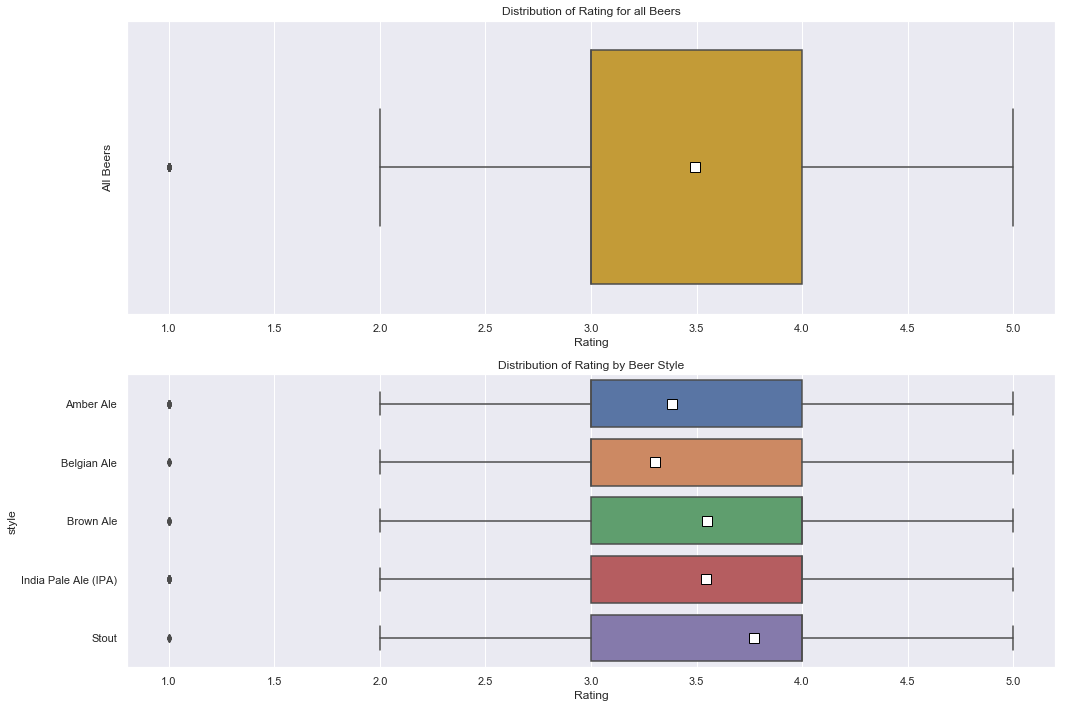

In [15]:
rating_box_plot(rater="appearance", df1=beer, df2=beersmall)

For this scale it appears that most rating left were either a 3 or 4. The spread appears the same for all six groups.
Looking at the averages, shows a little bit more:
+ Stouts on average are rated the highest in appearance
+ IPAs and Brown Ales have very similar average ratings
+ Overall all beers in this dataset have an approx. average rating of 3.5

Sometimes brands of beers with little reviews might skew the data. Let's see what the average rating is for brands of beer that have over 10 reviews.  

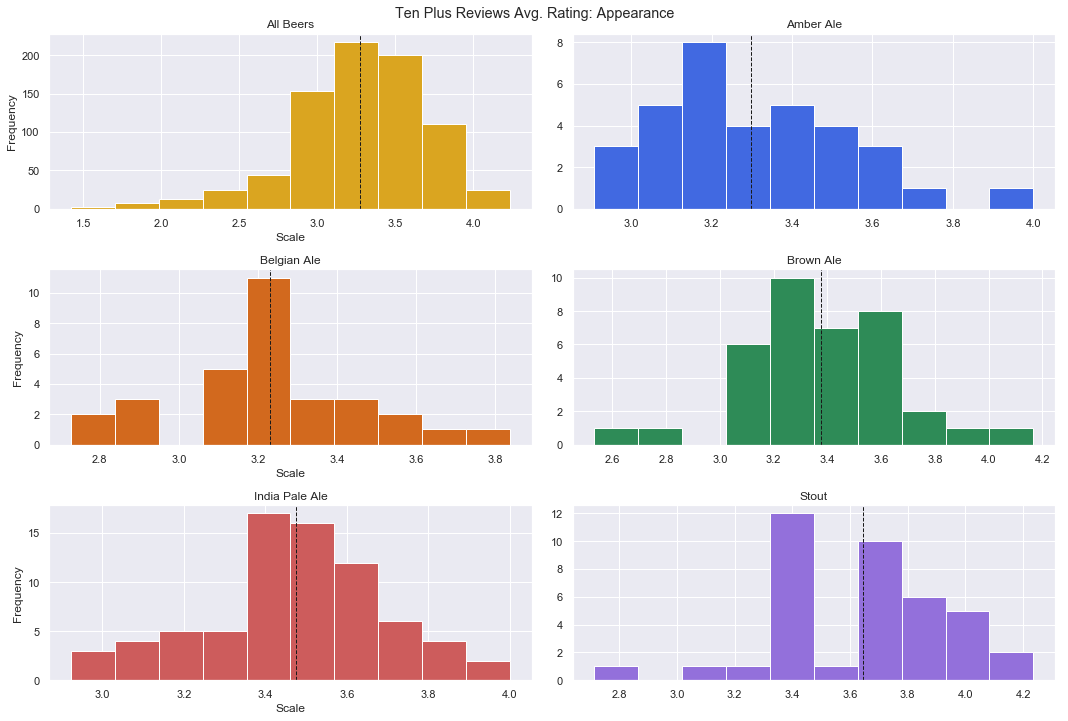

In [16]:
plt.figure(figsize=(15,10))

plt.subplot(321)
ten_plus_reviews(beer, col='name', rater='appearance', c='goldenrod')
plt.title('All Beers')
plt.xlabel('Scale')
plt.ylabel('Frequency')

plt.subplot(322)
ten_plus_reviews(amber, col='name', rater='appearance', c='royalblue')
plt.title('Amber Ale')

plt.subplot(323)
ten_plus_reviews(belgian, col='name', rater='appearance', c='chocolate')
plt.title('Belgian Ale')
plt.xlabel('Scale')
plt.ylabel('Frequency')

plt.subplot(324)
ten_plus_reviews(brown, col='name', rater='appearance', c='seagreen')
plt.title('Brown Ale')

plt.subplot(325)
ten_plus_reviews(ipa, col='name', rater='appearance', c='indianred')
plt.title('India Pale Ale')
plt.xlabel('Scale')
plt.ylabel('Frequency')

plt.subplot(326)
ten_plus_reviews(stout, col='name', rater='appearance', c='mediumpurple')
plt.title('Stout')

plt.tight_layout()
plt.suptitle('Ten Plus Reviews Avg. Rating: Appearance', y=1)
plt.show()

When looking at the average rating for beers with more than 10 reviews, the overall appearance rating drops closer to 3.25. Otherwise the averages appear to remain very similar when including all beers. 

Let's move on now to look at the "Palate" of the beer. An easier way to digest this is how it feels when you take a sip into your mouth. I will leave points of emphasis in bullet points and then summarize and the end of analyzing all rating scales.

### Feel

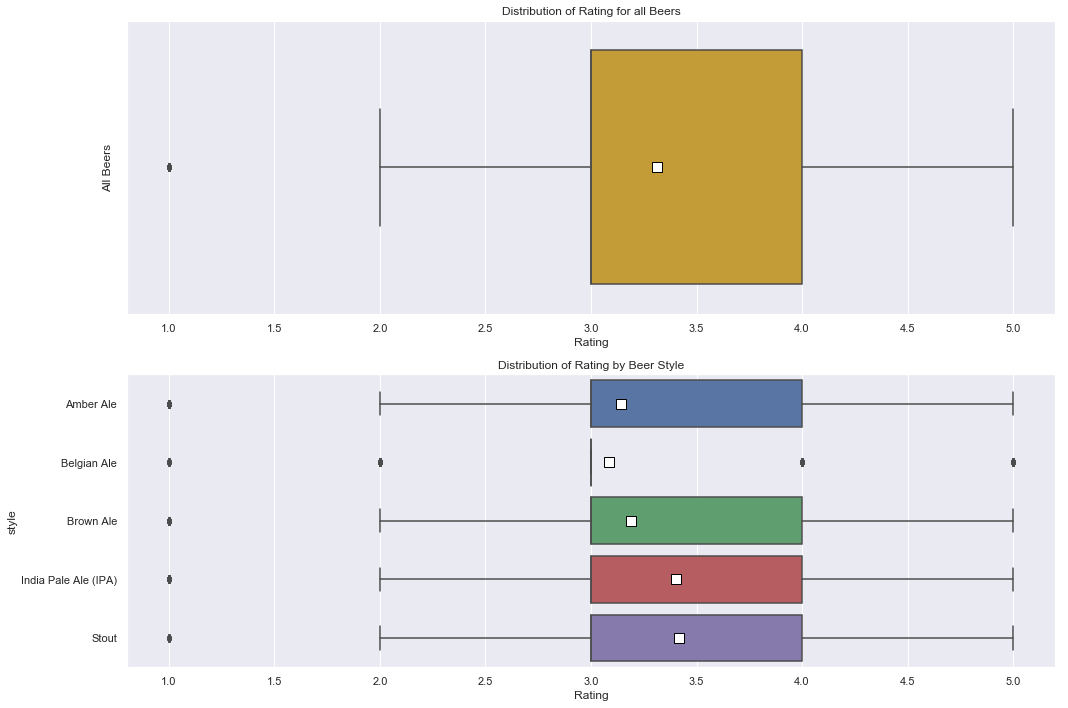

In [17]:
rating_box_plot(rater='palate', df1=beer, df2=beersmall)

+ Ratings again spread mainly between 3 and 4. They appear to be leaning more towards a value of 3. 
+ IPA and Stout have similar average ratings
+ Brown Ales, Amber Ales and All beers have similar average ratings
+ Belgian Ale has the lowest average rating

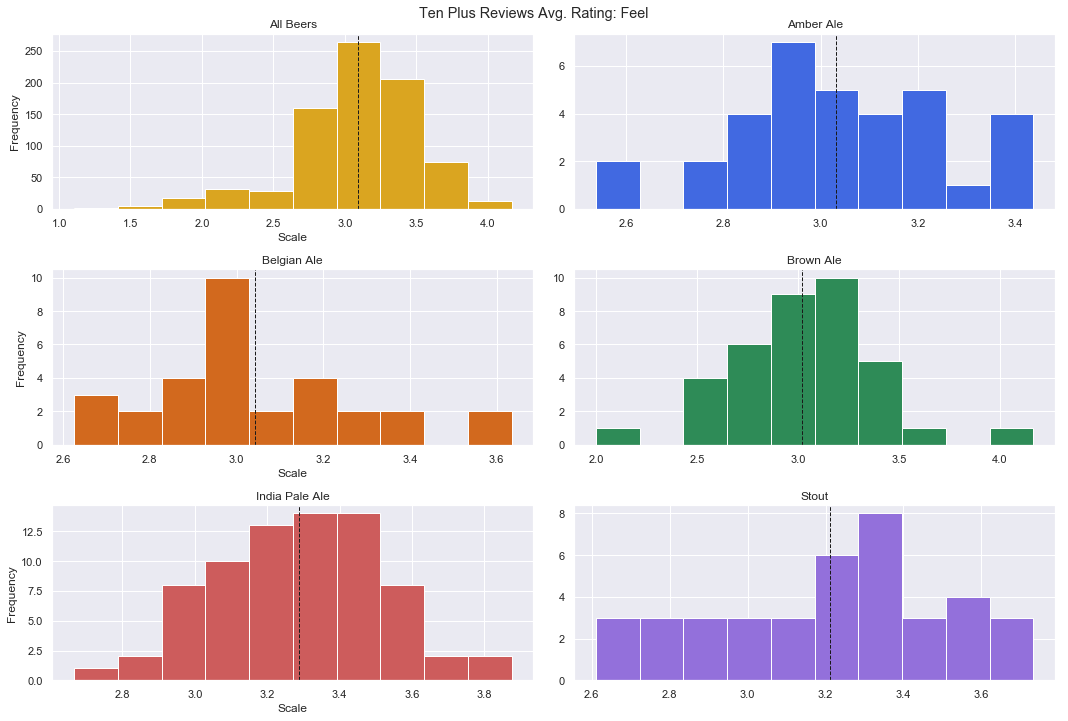

In [18]:
plt.figure(figsize=(15,10))

plt.subplot(321)
ten_plus_reviews(beer, col='name', rater='palate', c='goldenrod')
plt.title('All Beers')
plt.xlabel('Scale')
plt.ylabel('Frequency')

plt.subplot(322)
ten_plus_reviews(amber, col='name', rater='palate', c='royalblue')
plt.title('Amber Ale')

plt.subplot(323)
ten_plus_reviews(belgian, col='name', rater='palate', c='chocolate')
plt.title('Belgian Ale')
plt.xlabel('Scale')
plt.ylabel('Frequency')

plt.subplot(324)
ten_plus_reviews(brown, col='name', rater='palate', c='seagreen')
plt.title('Brown Ale')

plt.subplot(325)
ten_plus_reviews(ipa, col='name', rater='palate', c='indianred')
plt.title('India Pale Ale')
plt.xlabel('Scale')
plt.ylabel('Frequency')

plt.subplot(326)
ten_plus_reviews(stout, col='name', rater='palate', c='mediumpurple')
plt.title('Stout')

plt.tight_layout()
plt.suptitle('Ten Plus Reviews Avg. Rating: Feel', y=1)
plt.show()

+ There do not appear to be major differences when looking only at beers with more than 10 reviews.

### Taste

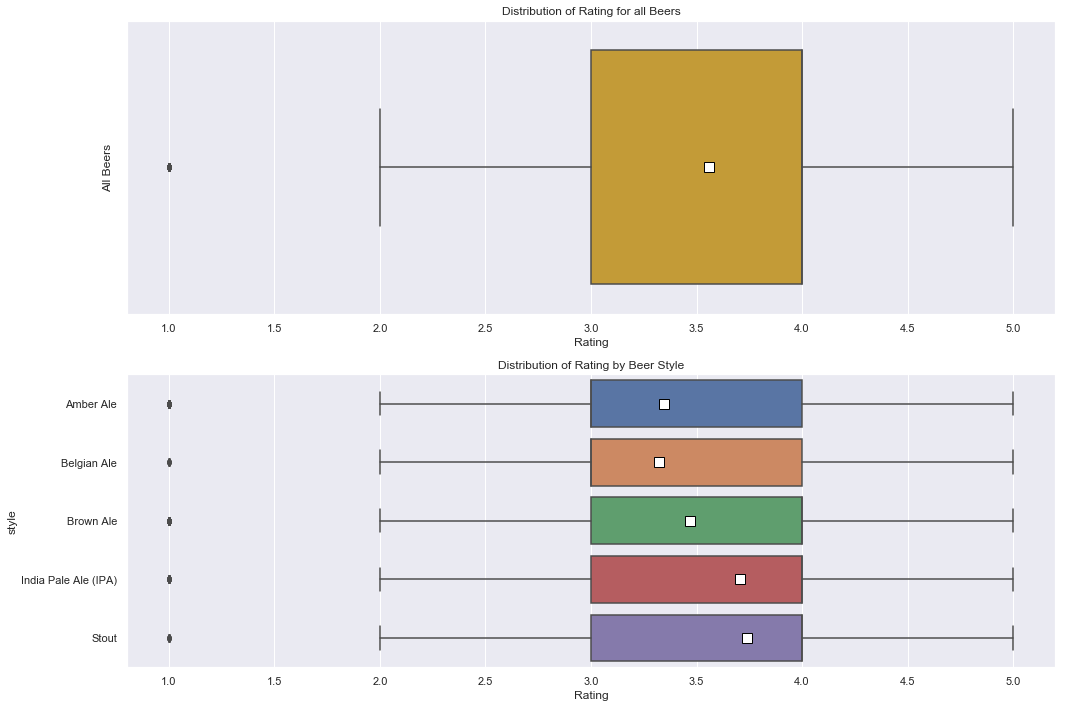

In [19]:
rating_box_plot(rater='taste', df1=beer, df2=beersmall)

+ Overall the beers have a rough average rating of 3.5. Brown Ales follow this similar pattern.
+ IPAs and Stouts have the highest average ratings leaning closer to a 4 value.
+ Amber and Belgian Ales have lower average ratings leaning closer to a 3 value. 

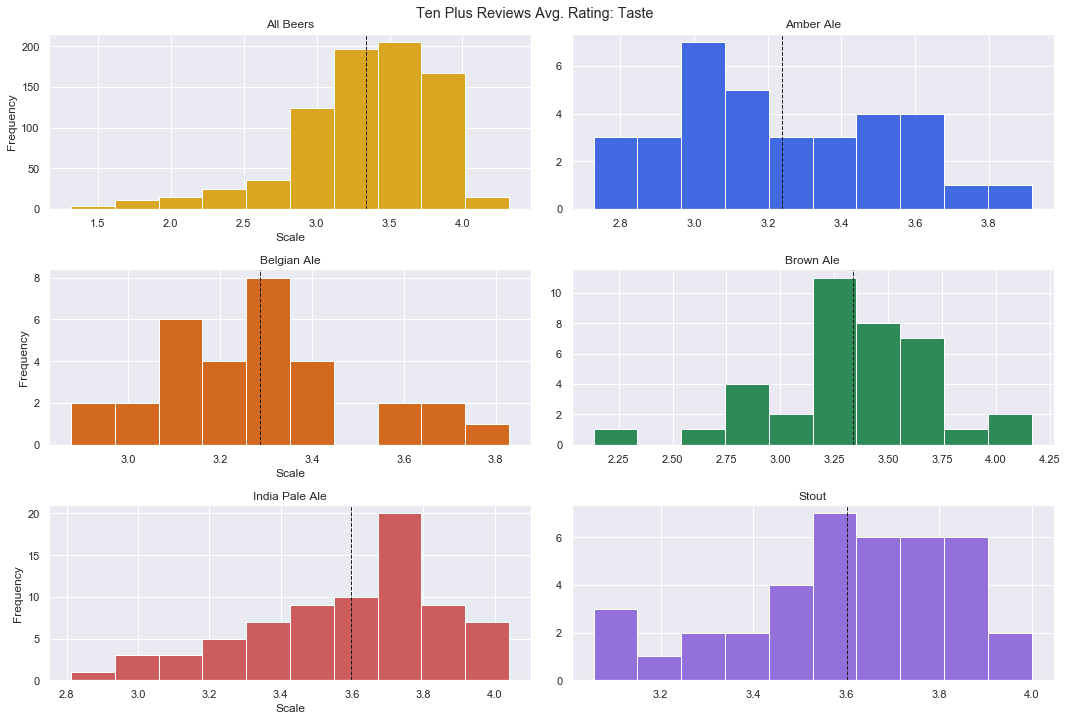

In [20]:
plt.figure(figsize=(15,10))

plt.subplot(321)
ten_plus_reviews(beer, col='name', rater='taste', c='goldenrod')
plt.title('All Beers')
plt.xlabel('Scale')
plt.ylabel('Frequency')

plt.subplot(322)
ten_plus_reviews(amber, col='name', rater='taste', c='royalblue')
plt.title('Amber Ale')

plt.subplot(323)
ten_plus_reviews(belgian, col='name', rater='taste', c='chocolate')
plt.title('Belgian Ale')
plt.xlabel('Scale')
plt.ylabel('Frequency')

plt.subplot(324)
ten_plus_reviews(brown, col='name', rater='taste', c='seagreen')
plt.title('Brown Ale')

plt.subplot(325)
ten_plus_reviews(ipa, col='name', rater='taste', c='indianred')
plt.title('India Pale Ale')
plt.xlabel('Scale')
plt.ylabel('Frequency')

plt.subplot(326)
ten_plus_reviews(stout, col='name', rater='taste', c='mediumpurple')
plt.title('Stout')

plt.tight_layout()
plt.suptitle('Ten Plus Reviews Avg. Rating: Taste', y=1)
plt.show()

+ Brown ales have a slightly lower average when looking at beers with more than 10 reviews
+ Otherwise averages remain to be very similar

### Aroma

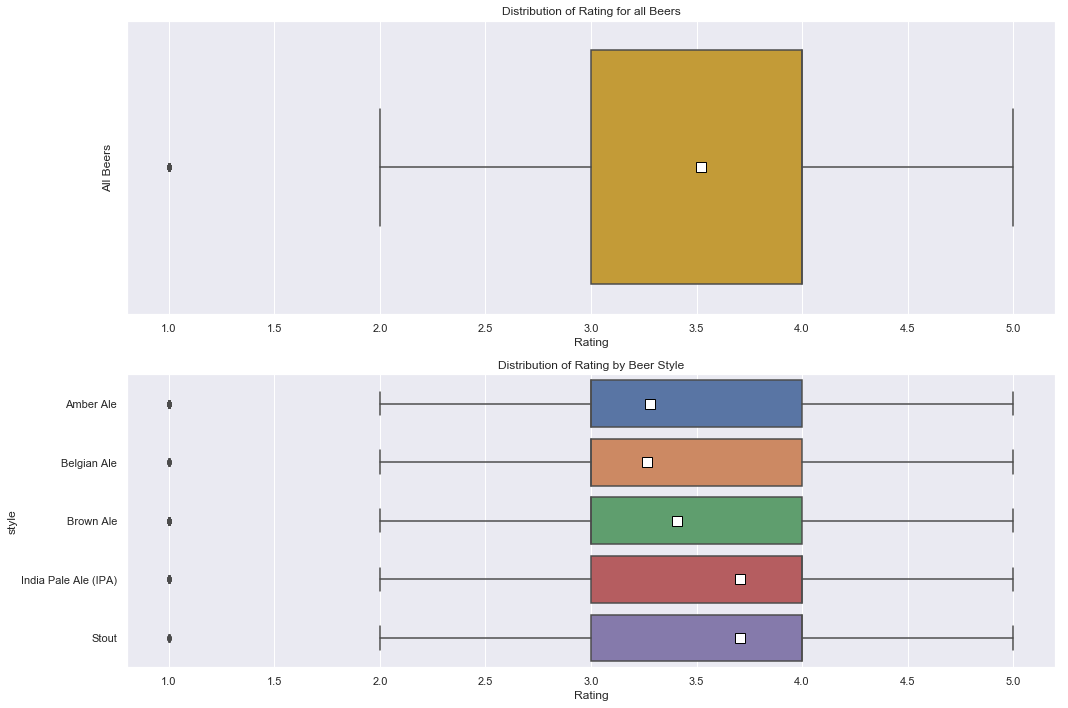

In [21]:
rating_box_plot(rater='aroma', df1=beer, df2=beersmall)

+ Aroma has similar averages to the taste distribution 

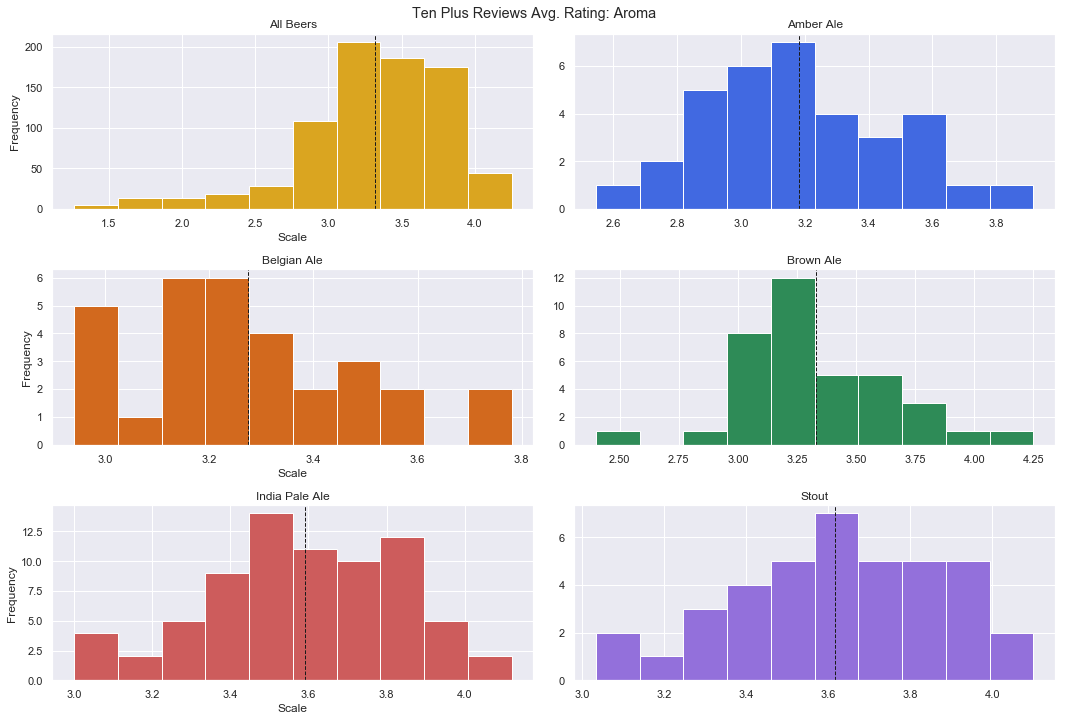

In [22]:
plt.figure(figsize=(15,10))

plt.subplot(321)
ten_plus_reviews(beer, col='name', rater='aroma', c='goldenrod')
plt.title('All Beers')
plt.xlabel('Scale')
plt.ylabel('Frequency')

plt.subplot(322)
ten_plus_reviews(amber, col='name', rater='aroma', c='royalblue')
plt.title('Amber Ale')

plt.subplot(323)
ten_plus_reviews(belgian, col='name', rater='aroma', c='chocolate')
plt.title('Belgian Ale')
plt.xlabel('Scale')
plt.ylabel('Frequency')

plt.subplot(324)
ten_plus_reviews(brown, col='name', rater='aroma', c='seagreen')
plt.title('Brown Ale')

plt.subplot(325)
ten_plus_reviews(ipa, col='name', rater='aroma', c='indianred')
plt.title('India Pale Ale')
plt.xlabel('Scale')
plt.ylabel('Frequency')

plt.subplot(326)
ten_plus_reviews(stout, col='name', rater='aroma', c='mediumpurple')
plt.title('Stout')

plt.tight_layout()
plt.suptitle('Ten Plus Reviews Avg. Rating: Aroma', y=1)
plt.show()

+ Again, looking at averages for beers with more than 10 reviews is similar to the taste rating scale

### Overall

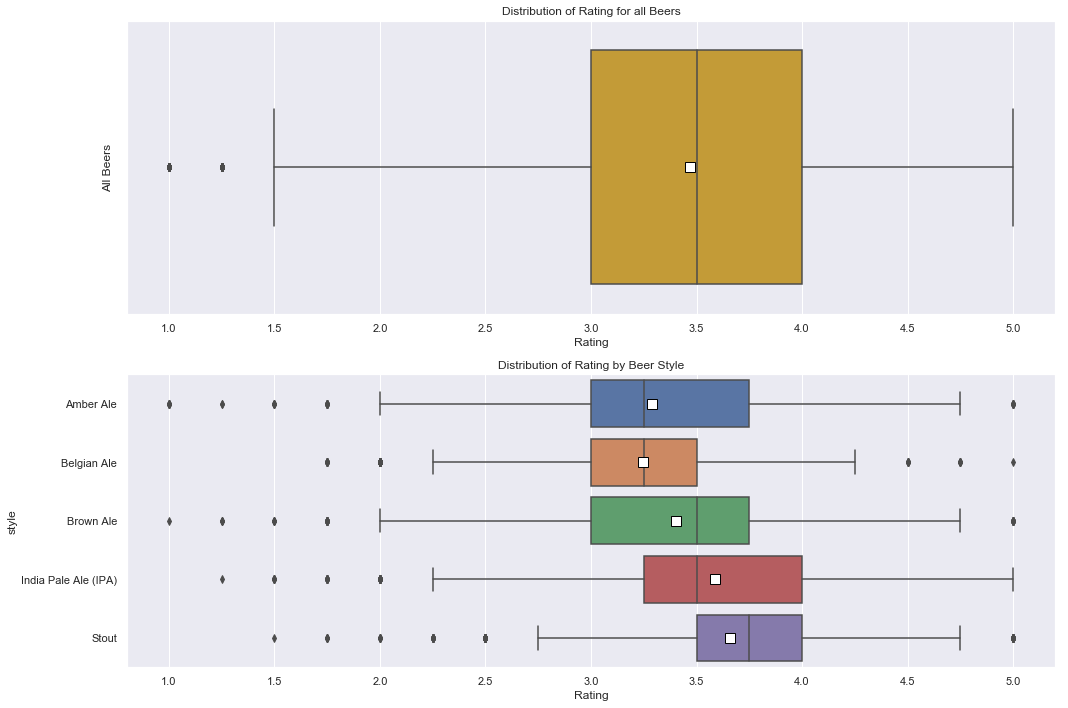

In [23]:
rating_box_plot(rater='overall', df1=beer, df2=beersmall)

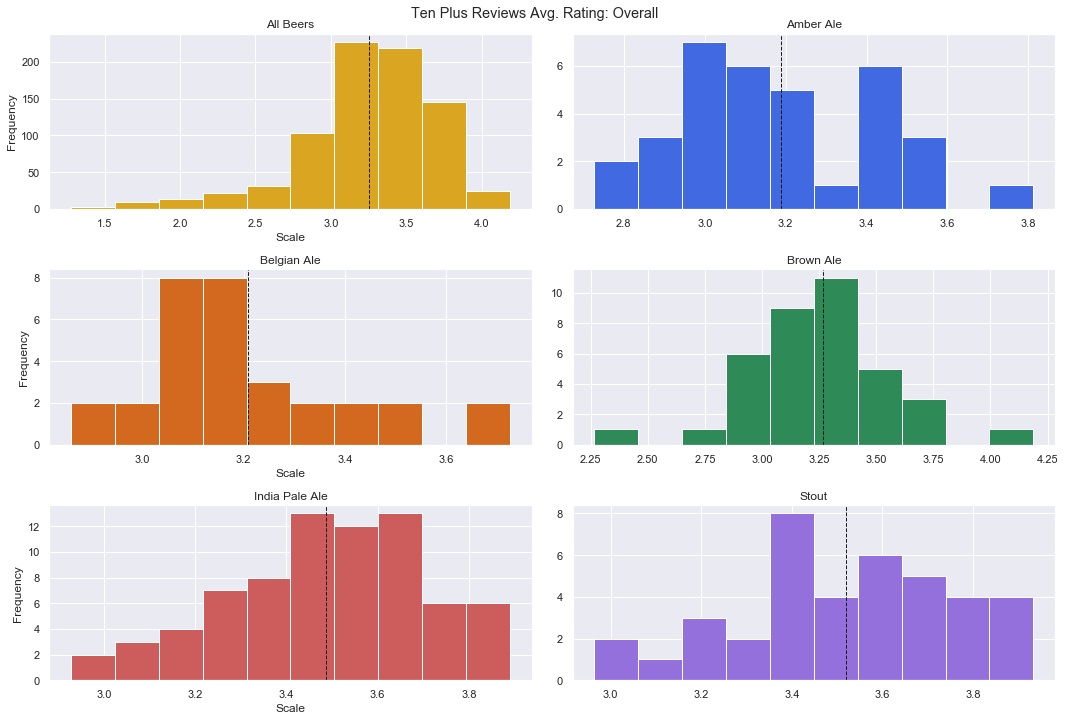

In [24]:
plt.figure(figsize=(15,10))

plt.subplot(321)
ten_plus_reviews(beer, col='name', rater='overall', c='goldenrod')
plt.title('All Beers')
plt.xlabel('Scale')
plt.ylabel('Frequency')

plt.subplot(322)
ten_plus_reviews(amber, col='name', rater='overall', c='royalblue')
plt.title('Amber Ale')

plt.subplot(323)
ten_plus_reviews(belgian, col='name', rater='overall', c='chocolate')
plt.title('Belgian Ale')
plt.xlabel('Scale')
plt.ylabel('Frequency')

plt.subplot(324)
ten_plus_reviews(brown, col='name', rater='overall', c='seagreen')
plt.title('Brown Ale')

plt.subplot(325)
ten_plus_reviews(ipa, col='name', rater='overall', c='indianred')
plt.title('India Pale Ale')
plt.xlabel('Scale')
plt.ylabel('Frequency')

plt.subplot(326)
ten_plus_reviews(stout, col='name', rater='overall', c='mediumpurple')
plt.title('Stout')

plt.tight_layout()
plt.suptitle('Ten Plus Reviews Avg. Rating: Overall', y=1)
plt.show()

###  Rating Scale Summary
From the plots and data observed, it appears that the Overall, Aroma, Feel and Taste scale follow similar patterns. 
+ Stout and IPA have the highest average ratings leaning closer to the value of 4. Both have similar ratings
+ Brown Ales resemble the distribution of the entire dataset combined together.
+ Belgian Ales and Amber Ales have the lowest average ratings leaning closer to the value of 3.

For the Appearance scale it is a little bit different.
+ Stouts have the highest average rating 
+ Brown Ales and IPAs have similar average ratings. Slightly leaning towards the 4 value they are very close to the middle.
+ Amber Ales follow the trend of the entire dataset also near the middle value but leaning slightly towards the 3 value.
+ Belgian Ales consistently had a lower average rating amongst all scales include Appearance.

Based off the data if I were to rank the six different styles from highest ratings to lowest they would be in the following order:
1. Stout
2. IPA
3. Brown Ales
4. Overall Dataset
5. Amber Ales
6. Belgian Ales

Now let's explore the text reviews some more. After all they will be the main ingredient in creating a successful model to predict the ratings.

## Word Count per Review
Let's look at the word count for reviews. We will check for normality using a Q-Q plot.

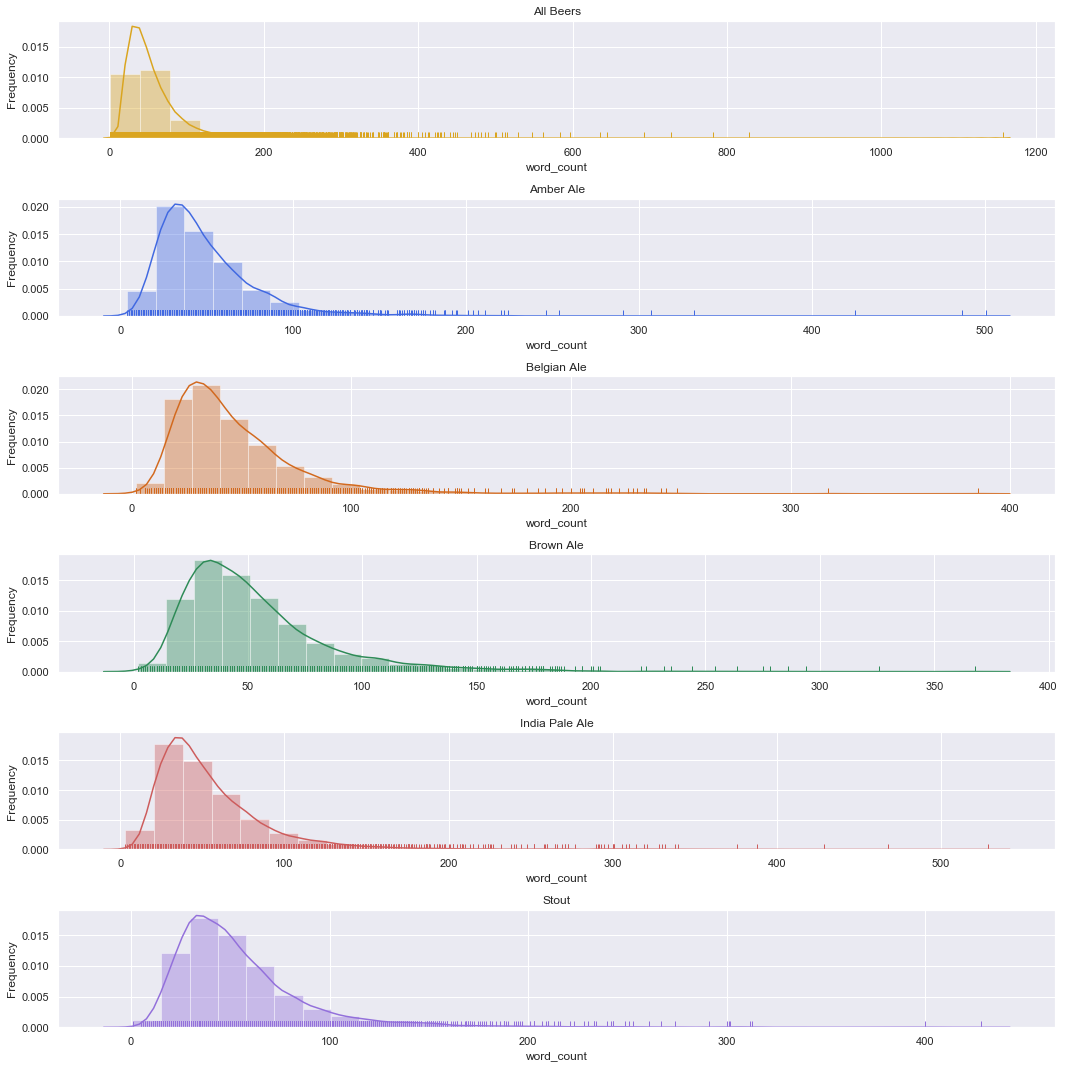

In [25]:
plt.figure(figsize=(15,15))

plt.subplot(611)
sns.distplot(beer.word_count, bins=30, kde=True, rug=True, color='goldenrod')
plt.title('All Beers')
plt.ylabel('Frequency')

plt.subplot(612)
sns.distplot(amber.word_count, bins=30, kde=True, rug=True, color='royalblue')
plt.title('Amber Ale')
plt.ylabel('Frequency')

plt.subplot(613)
sns.distplot(belgian.word_count, bins=30, kde=True, rug=True, color='chocolate')
plt.title('Belgian Ale')
plt.ylabel('Frequency')

plt.subplot(614)
sns.distplot(brown.word_count, bins=30, kde=True, rug=True, color='seagreen')
plt.title('Brown Ale')
plt.ylabel('Frequency')

plt.subplot(615)
sns.distplot(ipa.word_count, bins=30, kde=True, rug=True, color='indianred')
plt.title('India Pale Ale')
plt.ylabel('Frequency')

plt.subplot(616)
sns.distplot(stout.word_count, bins=30, kde=True, rug=True, color='mediumpurple')
plt.title('Stout')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

With a few exceptions, the majority of reviews have less than 100 words. This is expected because people usually do not write paragraphs or essays as reviews unless they are eagerly excited about a product or extremely disappointed, or they just like to express their opinions in detail.

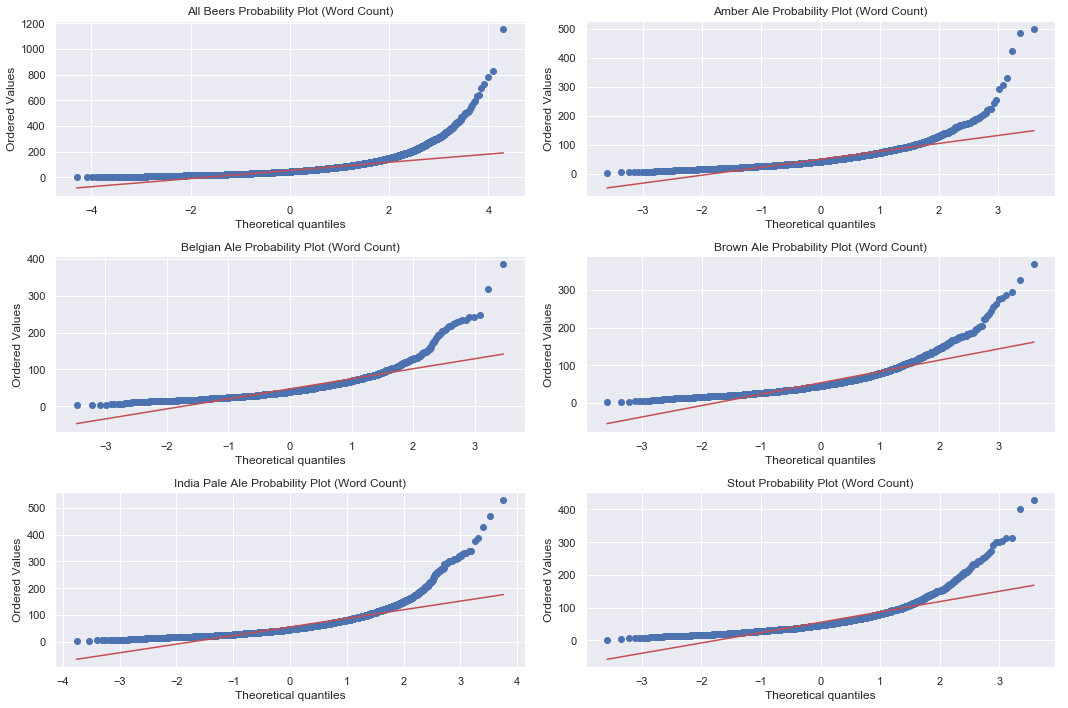

In [26]:
plt.figure(figsize=(15,10))

plt.subplot(321)
scipy.stats.probplot(beer.word_count, dist='norm', fit=True, plot=plt)
plt.title('All Beers Probability Plot (Word Count)')

plt.subplot(322)
scipy.stats.probplot(amber.word_count, dist='norm', fit=True, plot=plt)
plt.title('Amber Ale Probability Plot (Word Count)')

plt.subplot(323)
scipy.stats.probplot(belgian.word_count, dist='norm', fit=True, plot=plt)
plt.title('Belgian Ale Probability Plot (Word Count)')

plt.subplot(324)
scipy.stats.probplot(brown.word_count, dist='norm', fit=True, plot=plt)
plt.title('Brown Ale Probability Plot (Word Count)')

plt.subplot(325)
scipy.stats.probplot(ipa.word_count, dist='norm', fit=True, plot=plt)
plt.title('India Pale Ale Probability Plot (Word Count)')

plt.subplot(326)
scipy.stats.probplot(stout.word_count, dist='norm', fit=True, plot=plt)
plt.title('Stout Probability Plot (Word Count)')

plt.tight_layout()
plt.show()

Because the data is skewed to the right by the reviewers who left behind essays, the log of the word count needs to be taken to get a better understanding on whether or not the data is normal.

In [27]:
# Take the log for word_count for each style of beer and the entire dataframe as a whole
ipa = ipa.assign(log_word_count = lambda x: np.log(x.word_count))
stout = stout.assign(log_word_count = lambda x: np.log(x.word_count))
amber = amber.assign(log_word_count = lambda x: np.log(x.word_count))
brown = brown.assign(log_word_count = lambda x: np.log(x.word_count))
belgian = belgian.assign(log_word_count = lambda x: np.log(x.word_count))
beersmall = beersmall.assign(log_word_count = lambda x: np.log(x.word_count))
beer = beer.assign(log_word_count = lambda x: np.log(x.word_count))

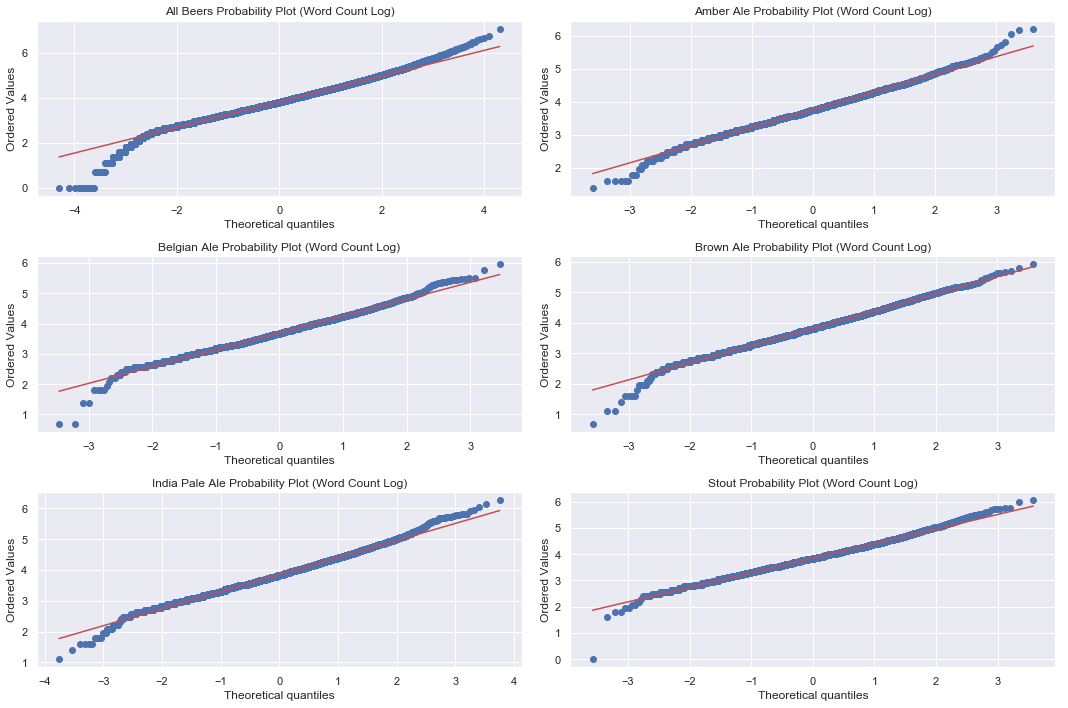

In [28]:
plt.figure(figsize=(15,10))

plt.subplot(321)
scipy.stats.probplot(beer.log_word_count, dist='norm', fit=True, plot=plt)
plt.title('All Beers Probability Plot (Word Count Log)')

plt.subplot(322)
scipy.stats.probplot(amber.log_word_count, dist='norm', fit=True, plot=plt)
plt.title('Amber Ale Probability Plot (Word Count Log)')

plt.subplot(323)
scipy.stats.probplot(belgian.log_word_count, dist='norm', fit=True, plot=plt)
plt.title('Belgian Ale Probability Plot (Word Count Log)')

plt.subplot(324)
scipy.stats.probplot(brown.log_word_count, dist='norm', fit=True, plot=plt)
plt.title('Brown Ale Probability Plot (Word Count Log)')

plt.subplot(325)
scipy.stats.probplot(ipa.log_word_count, dist='norm', fit=True, plot=plt)
plt.title('India Pale Ale Probability Plot (Word Count Log)')

plt.subplot(326)
scipy.stats.probplot(stout.log_word_count, dist='norm', fit=True, plot=plt)
plt.title('Stout Probability Plot (Word Count Log)')

plt.tight_layout()
plt.show()

Now it is more clear that the word_count looks fairly normal. 


## Engineered Features
The majority of reviews fell between 3 and 4 on the rating scale of 1-5. To compare reviews further I created two types of features to further examine. These were used to examine if there were differences within the text reviews between different ratings in the scale.

The first is a three category for rating scales of appearance, aroma, palate and taste. Reviews with a rating from 1-2 were considered "low", reviews with a rating of 3 were considered "medium" and reviews with a rating of 4-5 were considered "high". 

The second is a two category feature for the overall rating scale. Reviews less than 3.5 were considered "low" and reviews greater than or equal to 3.5 were considered "high". 

### 3-Rating Feature

In [29]:
def convert_ratings(df, col_name, rater):
    """ Convert the 5 star rating for a specific column in a dataframe into three groups.
        low - 1,2
        medium - 3
        high - 4,5
    """
    df[col_name] = np.where(df[rater] > 3, 'high', 
             (np.where(df[rater] < 3, 'low', 'medium')))

In [31]:
# Create a new column "high_low" where ratings below 3.5 are considered low and ratings above 3.5 are considered high
beersmall['high_low'] = np.where(beersmall['overall'] < 3.5, 'low', 'high')

In [32]:
convert_ratings(beersmall, col_name='3rate_appear', rater='appearance')
convert_ratings(beersmall, col_name='3rate_aroma', rater='aroma')
convert_ratings(beersmall, col_name='3rate_palate', rater='palate')
convert_ratings(beersmall, col_name='3rate_taste', rater='taste')

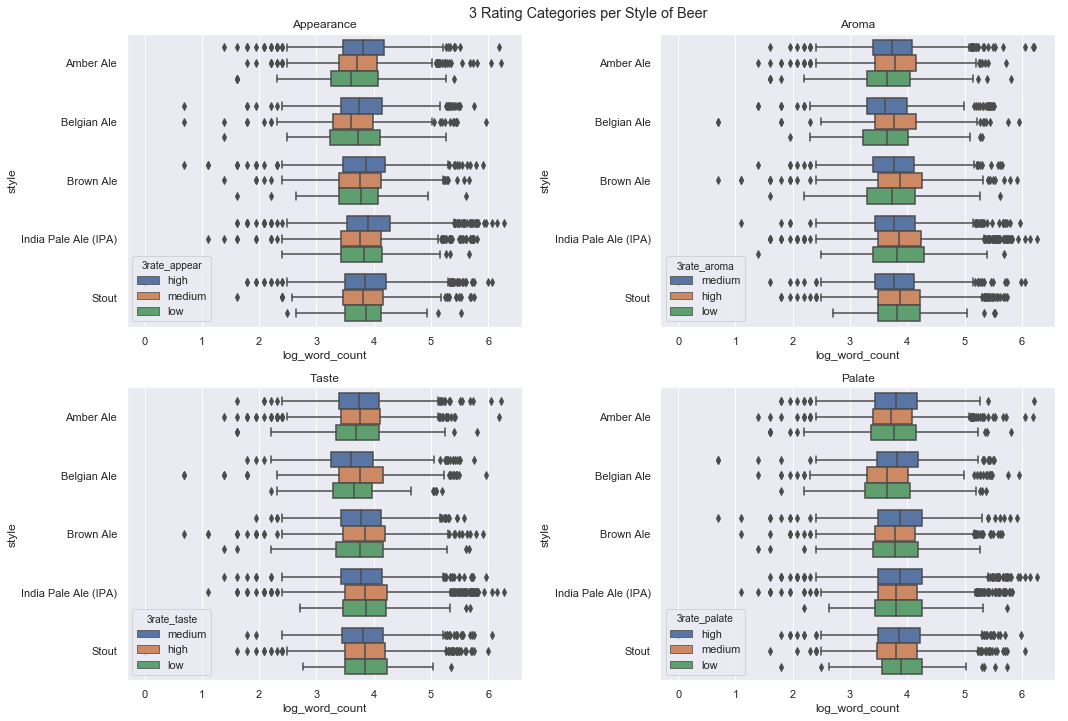

In [33]:
plt.figure(figsize=(15,10))

plt.subplot(221)
sns.boxplot(x='log_word_count', y='style', data=beersmall, hue='3rate_appear')
plt.title('Appearance')

plt.subplot(222)
sns.boxplot(x='log_word_count', y='style', data=beersmall, hue='3rate_aroma')
plt.title('Aroma')

plt.subplot(223)
sns.boxplot(x='log_word_count', y='style', data=beersmall, hue='3rate_taste')
plt.title('Taste')

plt.subplot(224)
sns.boxplot(x='log_word_count', y='style', data=beersmall, hue='3rate_palate')
plt.title('Palate')

plt.suptitle('3 Rating Categories per Style of Beer',x=.55, y=1)
plt.tight_layout()
plt.show()

### 2 Rating Feature: Overall

Text(0.5, 1.0, '2 Rating Categories per Style of Beer (Overall)')

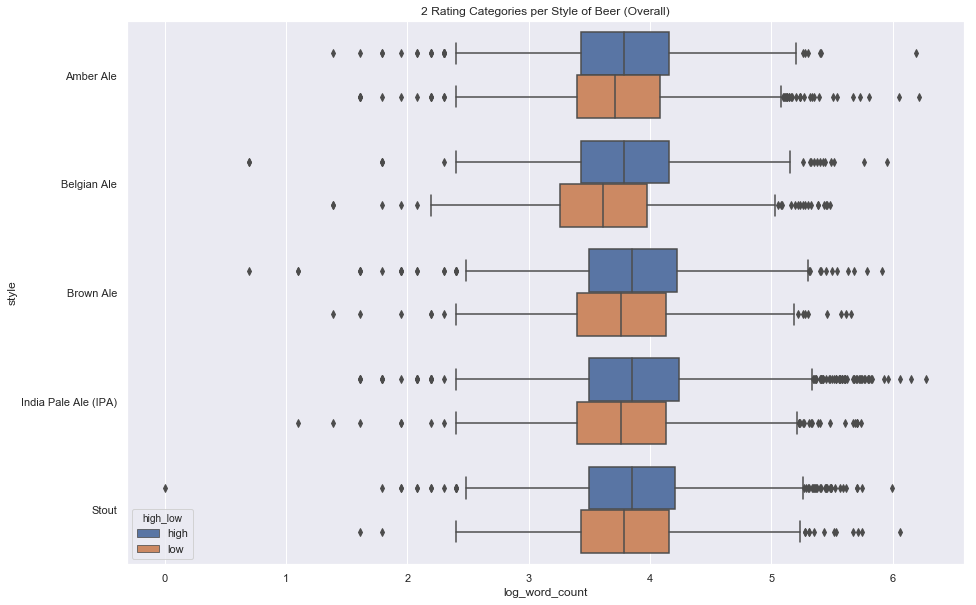

In [34]:
plt.figure(figsize=(15,10))
sns.boxplot(x='log_word_count', y='style', data=beersmall, hue='high_low')
plt.title('2 Rating Categories per Style of Beer (Overall)')

## Word Frequencies and Word Clouds

In [44]:
def word_freq_plot(df, col):
    """Take a column from a dataframe and split the words within each review. Then combine them back together into one list.
       After create a frequency distribution plot to determine the frequency of the words.
    """
    words = "".join(df[col].apply(str)).split()
    freqdist = nltk.FreqDist(words)
    freqdist.plot(25)
    
def word_cloud(df, col):
    """Take a given column of reviews and create a word cloud from it."""
    
    all_words = ''
    df[col].dropna(inplace=True)
    for val in df[col]:
        tokens = word_tokenize(val)
        for words in tokens:
            all_words = all_words + ' ' + words
        
    wordcloud = WordCloud(max_words=1000, width=600, height=400).generate(all_words)
    
    plt.figure( figsize=(10,8), facecolor='black')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

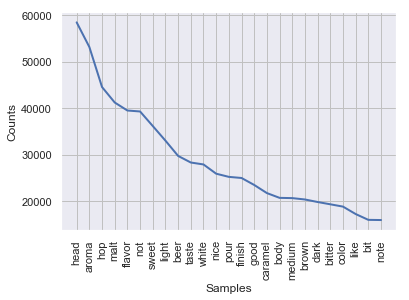

In [45]:
word_freq_plot(beer, col='clean_text_lem')

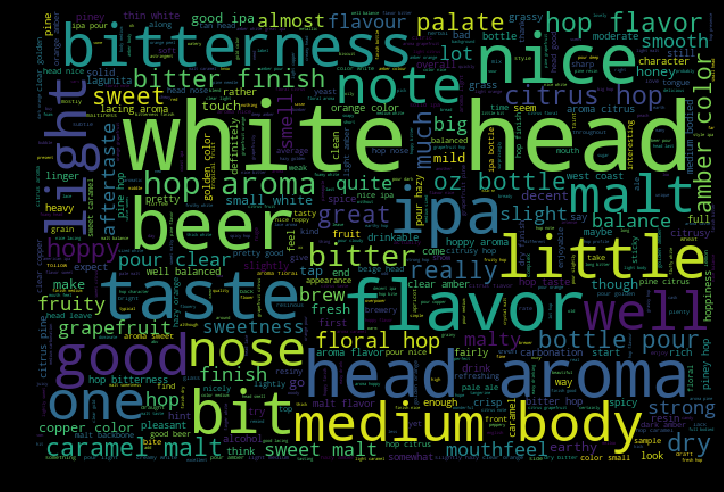

In [47]:
word_cloud(ipa, col='clean_text_lem')

In [ ]:
#beer.to_csv(r'C:\Users\soham\OneDrive\Desktop\Springboard\beerML.csv')

In [ ]:
#beer.to_pickle('beerML.pickle')

## Conclusion
From the Exploratory Analysis we can come up with some points:
+ There are many different styles and even more number of brands of beer. A majority of them do not have many reviews. Something to look into in further exploration would be to combine similar styles of beer. 
+ The majority of text ratings fall between 3 and 4. Ratings of 1,2 and 5 are very small in comparison for all beers. 
+ Ratings on average appear to be around the 3.75 overall rating mark with the majority of reviewers providing 4 star feedback amongst the various rating categories




## Sources
***
Lipton, Zachary & Vikram, Sharad & McAuley, Julian. (2015). Capturing Meaning in Product Reviews with Character-Level Generative Text Models.
https://www.researchgate.net/publication/283761921_Capturing_Meaning_in_Product_Reviews_with_Character-Level_Generative_Text_Models